Используем набор примеров fashion-MNIST

<ol>
<li>Опишите - какой результата получен в нейросети в зависимости от:
<ul>
    <li>числа нейронов в слое(для 2-хслойной сети),
    <li>числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).<br>
фиксируйте для тренировочного и тестового набора метрики accuracy.
</ul>
<li>Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.<br>Фиксируйте для тренировочного и тестового набора метрики accuracy.
<li>Сделайте вывод - что помогло вам улучшить качество классификации в нейросети на тестовом наборе?
<li>Для одного варианта сетей сформируйте матрицу ошибок по классам. <br>Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.
</ol>

In [1]:
import numpy as np
import time
import keras
from keras.datasets import mnist, boston_housing, fashion_mnist
from keras import Sequential
from keras.layers import Dense

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

Загрузка данных

In [2]:
(train_images,train_labels),(test_images, test_labels)=fashion_mnist.load_data()

train_images = (train_images / 255) * 2 - 1
test_images = (test_images / 255) * 2 - 1

train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

print(keras.backend.backend())
print(train_images.shape) # (60000, 784)
print(test_images.shape)  # (10000, 784)

tensorflow
(60000, 784)
(10000, 784)


In [3]:
def picview(pic_df, idx, grid=False, colorbar=False):
    shape = int(len(train_images[idx])**0.5)
    shape = (shape, shape)
    plt.grid(grid)
    plt.imshow((pic_df[idx,:].reshape(shape)+1)/2)
    if colorbar:
        plt.colorbar()
    plt.show()


def model_compiler(layers_list, compile_params,  display_model=True):
    compile_params_keys = list(compile_params.keys())
    
    if len( set(compile_params_keys) - set(['optimizer', 'loss', 'metrics']) ) > 0:
        raise KeyError('incorrect compile params name')
    
    model = Sequential()
    
    for layer in layers_list:
        model.add(layer)
    
    optimizer = compile_params['optimizer']
    loss = compile_params['loss']
    metrics = compile_params['metrics']
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    if display_model:
        model.summary()

    return model


def model_fit_valid(model, train_images,train_labels, n_classes, n_epochs=10, batch_size=32, 
                  validation_split=0.15, use_early_stopping=False, verbose_mode=0, show_chart=True):
    
    train_labels_cat = to_categorical(train_labels, n_classes)
    
    if use_early_stopping:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0.15*n_epochs)
        callbacks = [es]
    else:
        callbacks = None
    
    start_time = time.time()
    history = model.fit(train_images, train_labels_cat, epochs=n_epochs, batch_size=batch_size, 
                        validation_split=validation_split, shuffle=True, verbose=verbose_mode,
                        callbacks=callbacks)
    
    if show_chart:
        fig = plt.figure(figsize=(10, 4))
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='valid')
        plt.title('Accuracy')
        plt.legend()
        plt.show()
    
    best_idx = np.array(history.history['accuracy']).argmax()
    optimal_epoch_number = history.epoch[best_idx] + 1
    best_val_acc = history.history['val_accuracy'][best_idx]
    best_val_loss = history.history['val_loss'][best_idx]
    best_tr_acc = history.history['accuracy'][best_idx]
    
    print(f'Model with {len(model.layers)-2} hidden layers')
    print(f'Max accuracy train epoch number: {optimal_epoch_number}')
    print('params on optimal epoch:')
    print(f'accuracy on valid: {best_val_acc:.4f}, on train: {best_tr_acc:.4f}')
    print(f'best val loss: {best_val_loss}')
    print(f'refit finished in {(time.time()-start_time):1f} sec')
    print(40*'-'+' End '+40*'-'+'\n')      
    return model
    
        
def plot_confmatrix(y_true, y_pred, cmap=plt.cm.Blues,
                          show_cbar=False, font_size=11, font_style='normal', alpha=1,
                          linecolor='white', linewidths=0.1):

    cnf_matrix = confusion_matrix(y_true, y_pred)

    xticklabels = list(set(y_true))
    matrix = cnf_matrix[::-1]
    yticklabels = xticklabels[::-1]

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()

    annot_kws = {
        'fontsize': font_size,
        'fontstyle': font_style,
        'alpha': alpha
    }

    cbar_kws = {"orientation": "vertical",
                "shrink": 1,
                'extend': 'max',
                'extendfrac': 0.01,
                "drawedges": False,
                }

    ax.set_title('Confusion Matrix')

    sns.heatmap(matrix, square=True, ax=ax, cmap=cmap, annot=True, fmt='d',
                annot_kws=annot_kws, cbar=show_cbar, cbar_kws=cbar_kws, linecolor=linecolor,
                linewidths=linewidths, xticklabels=xticklabels, yticklabels=yticklabels)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    ax.set_ylim([0, len(matrix)])
    ax.set_xlabel('predicted class')
    ax.set_ylabel('true class')
    plt.show()
    
def model_predict(model, train_images, train_labels, test_images, test_labels, n_classes, 
                n_epochs=10, batch_size=32, refit_model_on_full_data=True, verbose_refit=0,
                show_metrics_on_test=True, show_conf_matrix=True):
    
    train_labels_cat = to_categorical(train_labels, n_classes)
    
    if refit_model_on_full_data:
        start_time = time.time()
        print('refit on full train (99%) dataset activated')
        model.fit(train_images, train_labels_cat, epochs=n_epochs, batch_size=batch_size, validation_split=0.01,
                 verbose=verbose_refit)
        print(f'refit succeed in {(time.time()-start_time):.1f} sec')
        print()
    
    start_time = time.time()
    predict = model.predict(test_images)
    print(f'predict generated in {(time.time()-start_time):.1f} sec')
    predict = np.argmax(predict, axis=1)
        
    if show_metrics_on_test:
        print(classification_report(test_labels, predict))
    
    if show_conf_matrix:
        plot_conf_matrix(test_labels, predict)
    
    return predict

In [4]:
#for i in range(30,34):
#    picview(train_images,i, colorbar=True)

### 1.1. Опишите - какой результата получен в 2-х слойной нейросети в зависимости от c числом нейронов в слое.

Используем модель с одинаковыми параметрами, при постоянном кол-ве эпох = 10. Увеливаем кол-во нейронов в 1 и 2ом слое по схеме [1,3,7,10,20,50,100]

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 128)               100480    
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
 dense_36 (Dense)            (None, 1)                 2         
                                                                 
 dense_37 (Dense)            (None, 10)                20        
                                                                 
Total params: 100,631
Trainable params: 100,631
Non-trainable params: 0
_________________________________________________________________


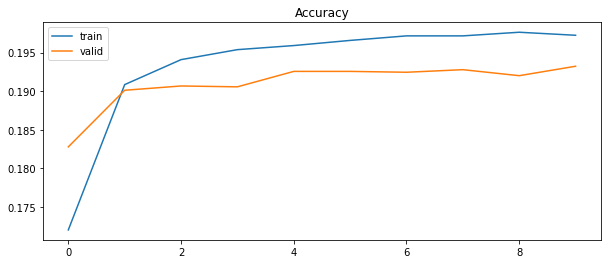

Model with 2 hidden layers
Max accuracy train epoch number: 9
params on optimal epoch:
accuracy on valid: 0.1920, on train: 0.1976
best val loss: 1.9331737756729126
refit finished in 6.968144 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 128)               100480    
                                                                 
 dense_39 (Dense)            (None, 3)                 387       
                                                                 
 dense_40 (Dense)            (None, 3)                 12        
                                                                 
 dense_41 (Dense)            (None, 10)                40        
                                                                 
Total params: 100,919
Trainable pa

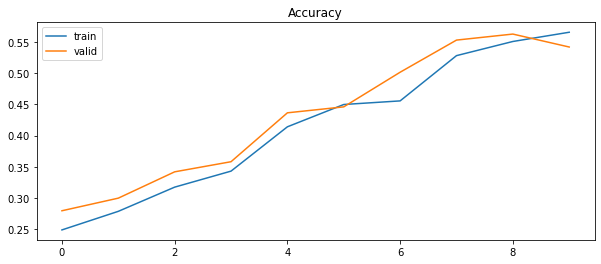

Model with 2 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.5420, on train: 0.5657
best val loss: 1.475770354270935
refit finished in 7.108977 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               100480    
                                                                 
 dense_43 (Dense)            (None, 7)                 903       
                                                                 
 dense_44 (Dense)            (None, 7)                 56        
                                                                 
 dense_45 (Dense)            (None, 10)                80        
                                                                 
Total params: 101,519
Trainable pa

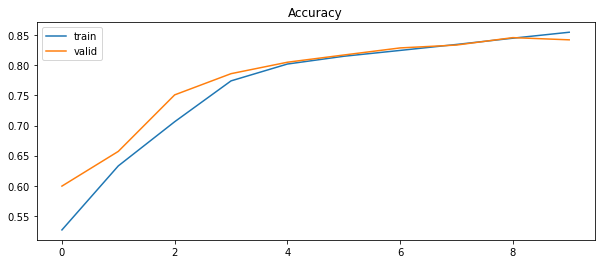

Model with 2 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8423, on train: 0.8549
best val loss: 0.7279804944992065
refit finished in 7.142491 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 128)               100480    
                                                                 
 dense_47 (Dense)            (None, 10)                1290      
                                                                 
 dense_48 (Dense)            (None, 10)                110       
                                                                 
 dense_49 (Dense)            (None, 10)                110       
                                                                 
Total params: 101,990
Trainable p

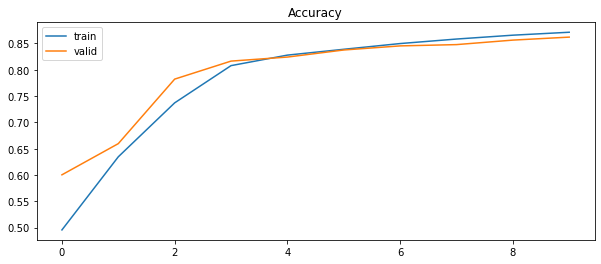

Model with 2 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8619, on train: 0.8712
best val loss: 0.5232349038124084
refit finished in 7.314012 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 128)               100480    
                                                                 
 dense_51 (Dense)            (None, 20)                2580      
                                                                 
 dense_52 (Dense)            (None, 20)                420       
                                                                 
 dense_53 (Dense)            (None, 10)                210       
                                                                 
Total params: 103,690
Trainable p

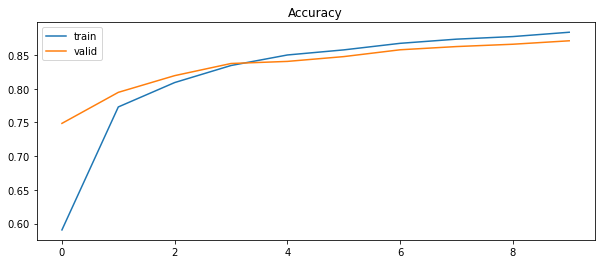

Model with 2 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8711, on train: 0.8838
best val loss: 0.3903854787349701
refit finished in 7.021393 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 128)               100480    
                                                                 
 dense_55 (Dense)            (None, 50)                6450      
                                                                 
 dense_56 (Dense)            (None, 50)                2550      
                                                                 
 dense_57 (Dense)            (None, 10)                510       
                                                                 
Total params: 109,990
Trainable p

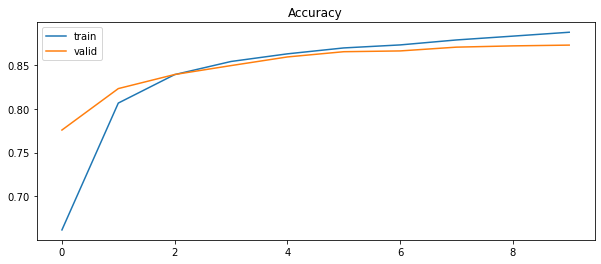

Model with 2 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8730, on train: 0.8877
best val loss: 0.3541654646396637
refit finished in 7.476781 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 128)               100480    
                                                                 
 dense_59 (Dense)            (None, 100)               12900     
                                                                 
 dense_60 (Dense)            (None, 100)               10100     
                                                                 
 dense_61 (Dense)            (None, 10)                1010      
                                                                 
Total params: 124,490
Trainable p

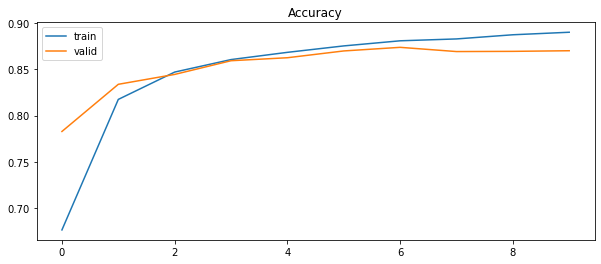

Model with 2 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8699, on train: 0.8898
best val loss: 0.3609657287597656
refit finished in 7.875278 sec
---------------------------------------- End ----------------------------------------



In [10]:
neiron_numbers = [1,3,7,10,20,50,100]
comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['accuracy']
}
for n in neiron_numbers:
    layer_in =  Dense(128, activation='relu', input_shape=(784,))
    layer_1 = Dense(n, activation='sigmoid',)
    layer_2 = Dense(n, activation='tanh')
    layer_out = Dense(10, activation='softmax')
    model_1 = model_compiler(layers_list=[layer_in, layer_1, layer_2, layer_out],
                              compile_params=comp_params)
    model_1 = model_fit_valid(model_1, train_images,train_labels, n_classes=10, n_epochs=10, batch_size=1024, 
                   validation_split=0.15, use_early_stopping=False, verbose_mode=0, show_chart=True)

В эксперименте количество нейронов в 1 и 2-ом скрытом уровне увеличивалось постепенно [1,3,7,10,20,50,100]. 
C увеличением кол-ва нейронов точность модели росла.

#### Вывод: чем больше было нейронов в слоях тем выше была точность. Но при количестве нейронов больше 10 рост точности для данной модели замедляется.

### 1.2.  Опишите - какой результата получен в (2, 3, 5, 10) слойной нейросети при близких размерах сети

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 128)               100480    
                                                                 
 dense_91 (Dense)            (None, 8)                 1032      
                                                                 
 dense_92 (Dense)            (None, 10)                90        
                                                                 
Total params: 101,602
Trainable params: 101,602
Non-trainable params: 0
_________________________________________________________________


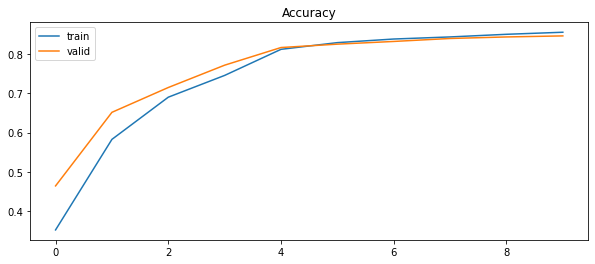

Model with 1 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8457, on train: 0.8550
best val loss: 0.8877847790718079
refit finished in 6.989864 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 128)               100480    
                                                                 
 dense_94 (Dense)            (None, 8)                 1032      
                                                                 
 dense_95 (Dense)            (None, 8)                 72        
                                                                 
 dense_96 (Dense)            (None, 10)                90        
                                                                 
Total params: 101,674
Trainable p

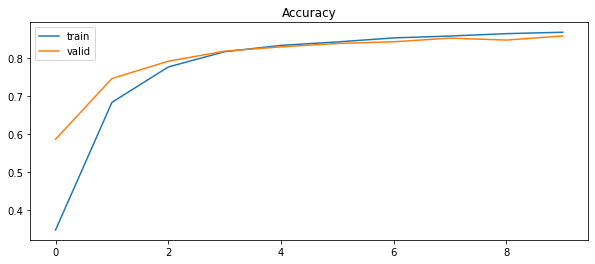

Model with 2 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.8576, on train: 0.8672
best val loss: 0.6371861696243286
refit finished in 7.082741 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 128)               100480    
                                                                 
 dense_98 (Dense)            (None, 8)                 1032      
                                                                 
 dense_99 (Dense)            (None, 8)                 72        
                                                                 
 dense_100 (Dense)           (None, 8)                 72        
                                                                 
 dense_101 (Dense)           (Non

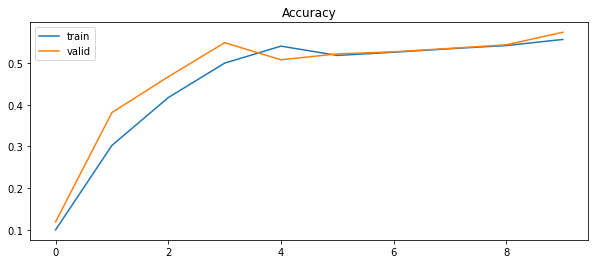

Model with 3 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.5746, on train: 0.5572
best val loss: 1.295006275177002
refit finished in 7.205089 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 128)               100480    
                                                                 
 dense_103 (Dense)           (None, 8)                 1032      
                                                                 
 dense_104 (Dense)           (None, 8)                 72        
                                                                 
 dense_105 (Dense)           (None, 8)                 72        
                                                                 
 dense_106 (Dense)           (None

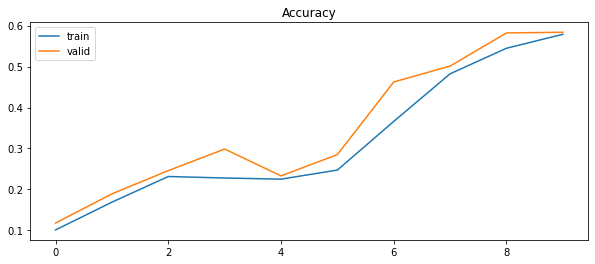

Model with 5 hidden layers
Max accuracy train epoch number: 10
params on optimal epoch:
accuracy on valid: 0.5838, on train: 0.5788
best val loss: 1.4967421293258667
refit finished in 7.364492 sec
---------------------------------------- End ----------------------------------------

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_109 (Dense)           (None, 128)               100480    
                                                                 
 dense_110 (Dense)           (None, 8)                 1032      
                                                                 
 dense_111 (Dense)           (None, 8)                 72        
                                                                 
 dense_112 (Dense)           (None, 8)                 72        
                                                                 
 dense_113 (Dense)           (Non

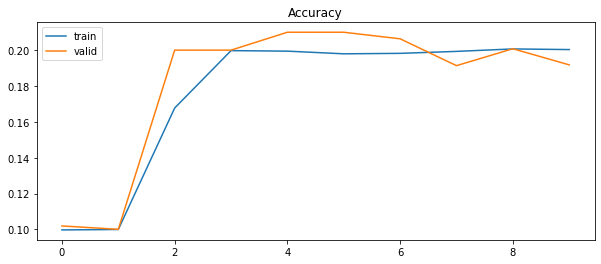

Model with 10 hidden layers
Max accuracy train epoch number: 9
params on optimal epoch:
accuracy on valid: 0.2009, on train: 0.2008
best val loss: 1.7281932830810547
refit finished in 7.944367 sec
---------------------------------------- End ----------------------------------------



In [12]:
neiron_numbers = 8
layers_numbers = [1, 2, 3, 5, 10]
comp_params = {
    'loss': 'categorical_crossentropy',
    'optimizer': 'adam',
    'metrics': ['accuracy']
}
for n in layers_numbers:
    layers = []
    layers.append(Dense(128, activation='relu', input_shape=(784,)))
    for i in range(n):
        if i % 2:
            layers.append(Dense(neiron_numbers, activation='tanh'))
        else:
            layers.append(Dense(neiron_numbers, activation='sigmoid'))
    layers.append(Dense(10, activation='softmax'))
    model_2 = model_compiler(layers_list=layers,compile_params=comp_params)
    model_2 = model_fit_valid(model_2, train_images,train_labels, n_classes=10, n_epochs=10, batch_size=1024, 
                   validation_split=0.15, use_early_stopping=False, verbose_mode=0, show_chart=True)

#### Вывод: при простом увеличении количества слоев точность модели падает.

### 2. Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.
Фиксируйте для тренировочного и тестового набора метрики accuracy.

In [ ]:
neiron_numbers = 12
epochs = 200
layers_numbers = [ 2]
comp_params = { 
        'loss': 'categorical_crossentropy',
        'metrics': ['accuracy']
    }
#optimizer_list = ['sgd','adam','rmsprop']
optimizer_list = ['sgd']
for opt in optimizer_list:
    comp_params = {'loss': 'categorical_crossentropy','metrics': ['accuracy']}
    for n in layers_numbers:
        layers = []
        layers.append(Dense(128, activation='relu', input_shape=(784,)))
        for i in range(n):
            if i % 2:
                layers.append(Dense(neiron_numbers, activation='tanh'))
            else:
                layers.append(Dense(neiron_numbers, activation='sigmoid'))
        layers.append(Dense(10, activation='softmax'))
        comp_params['optimizer'] = opt
        print(f'Optimizer = {opt}')
        model_2 = model_compiler(layers_list=layers,compile_params=comp_params)
        model_2 = model_fit_valid(model_2, train_images,train_labels, n_classes=10, n_epochs=epochs, batch_size=1024, 
                       validation_split=0.15, use_early_stopping=False, verbose_mode=1, show_chart=True)

Optimizer = sgd
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 128)               100480    
                                                                 
 dense_186 (Dense)           (None, 12)                1548      
                                                                 
 dense_187 (Dense)           (None, 12)                156       
                                                                 
 dense_188 (Dense)           (None, 10)                130       
                                                                 
Total params: 102,314
Trainable params: 102,314
Non-trainable params: 0
_________________________________________________________________
